In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn import preprocessing
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Baseline model

## Loading dataset

In [2]:
images = np.load('/content/drive/MyDrive/MaskDetection/images.npy')
labels = np.load('/content/drive/MyDrive/MaskDetection/labels.npy')

In [3]:
print(images.shape)

(9398, 80, 80, 3)


In [4]:
def make_preview(images, labels, n=25, len_per_image=2.6):
  sqrt_n = int(np.ceil(np.sqrt(n)))
  size = sqrt_n * len_per_image

  random_indices = np.random.choice(len(labels), size=n, replace=False)

  plt.figure(figsize=(size, size))
  for i, idx in enumerate(random_indices):
      image = images[idx]
      label = labels[idx]
      
      plt.subplot(sqrt_n, sqrt_n, i+1)
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
  plt.show()

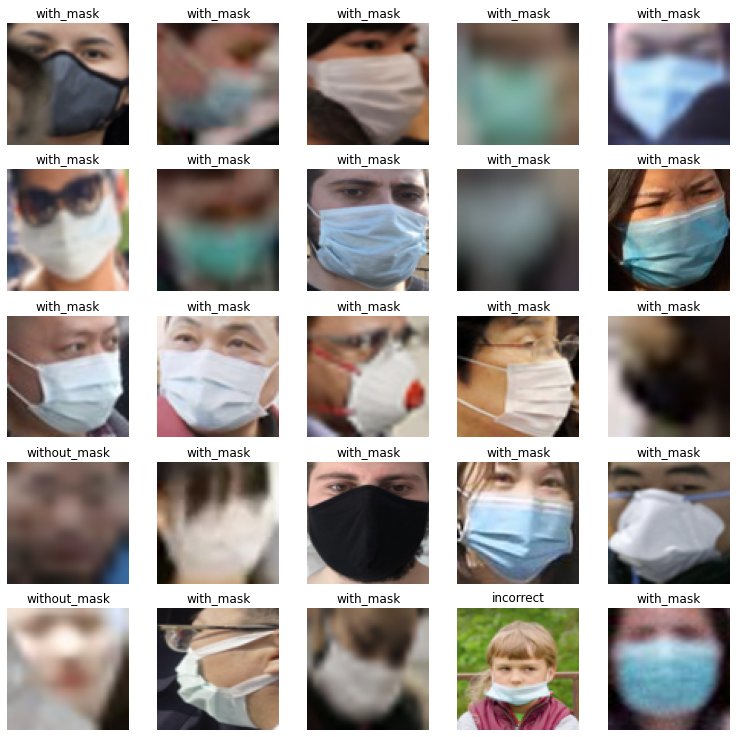

In [7]:
make_preview(images, labels)

## Splitting the data set into training and test data sets

In [8]:
# Divide dataset into classes
with_mask = np.where(labels == 'with_mask')
with_mask_data = images[with_mask]
with_mask_labels = labels[with_mask]

without_mask = np.where(labels == 'without_mask')
without_mask_data = images[without_mask]
without_mask_labels = labels[without_mask]

incorrect_mask = np.where(labels == 'incorrect')
incorrect_data = images[incorrect_mask]
incorrect_labels = labels[incorrect_mask]

In [9]:
print(len(with_mask_data), len(without_mask_data), len(incorrect_data))

6894 1984 520


In [10]:
def data_split(images, labels, test_size):
  if test_size < 1:
    test_size = int(len(images) * test_size)
  
  images, labels = shuffle(images, labels)
  X_test = images[:test_size]
  y_test = labels[:test_size]
  X_train = images[test_size:]
  y_train = labels[test_size:]

  return X_train, y_train, X_test, y_test

In [11]:
with_X_train, with_y_train, with_X_test, with_y_test = data_split(with_mask_data, with_mask_labels, 0.2)
print(len(with_X_train), len(with_X_test))

without_X_train, without_y_train, without_X_test, without_y_test = data_split(without_mask_data, without_mask_labels, 0.2)
print(len(without_X_train), len(without_X_test))

incorrect_X_train, incorrect_y_train, incorrect_X_test, incorrect_y_test = data_split(incorrect_data, incorrect_labels, 0.2)
print(len(incorrect_X_train), len(incorrect_X_test))

5516 1378
1588 396
416 104


In [12]:
X_train = np.concatenate([with_X_train, without_X_train, incorrect_X_train], axis=0)
y_train = np.concatenate([with_y_train, without_y_train, incorrect_y_train], axis=0)

X_test = np.concatenate([with_X_test, without_X_test, incorrect_X_test], axis=0)
y_test = np.concatenate([with_y_test, without_y_test, incorrect_y_test], axis=0)

print(len(X_train), len(X_test))

7520 1878


In [13]:
del with_X_train
del with_y_train
del with_X_test
del with_y_test

del without_X_train
del without_y_train
del without_X_test
del without_y_test

del incorrect_X_train
del incorrect_y_train
del incorrect_X_test
del incorrect_y_test

## Encoding labels

In [14]:
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [15]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

## Data Generator

In [16]:
def preprocess(image):
  return image / 127.5 - 1.0

In [17]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=20,
	  zoom_range=0.15,
	  width_shift_range=0.15,
	  height_shift_range=0.15,
	  shear_range=0.15,
	  horizontal_flip=True,
	  fill_mode="nearest",
    validation_split=0.2)

In [19]:
train_gen = gen.flow(
x=X_train,
y=y_train,
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True)

valid_gen = gen.flow(
x=X_train,
y=y_train,
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True)

In [20]:
init_lr = 1e-4
epochs = 20
batch_size = 64
input_shape = (80,80,3)
step_size_train = train_gen.n//batch_size
step_size_valid = valid_gen.n//batch_size

## Simple model

In [21]:
input = tf.keras.layers.Input(shape=input_shape)
out = tf.keras.layers.Conv2D(100, (3,3), activation='relu')(input)
out = tf.keras.layers.Conv2D(100, (3,3), strides=2, activation='relu')(input)
out = tf.keras.layers.Conv2D(100, (3,3), strides=2, activation='relu')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(50, activation='relu')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)
model = tf.keras.models.Model(input, out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [22]:
#training
H = model.fit(
	train_gen,
	steps_per_epoch=step_size_train,
  validation_data = valid_gen,
  validation_steps = step_size_valid,
	epochs=epochs)

Epoch 1/20
94/94 [==============================] - 19s 124ms/step - loss: 0.5666 - acc: 0.7844 - val_loss: 0.1673 - val_acc: 0.9463
Epoch 2/20
94/94 [==============================] - 11s 121ms/step - loss: 0.3502 - acc: 0.8829 - val_loss: 0.2024 - val_acc: 0.9626
Epoch 3/20
94/94 [==============================] - 11s 120ms/step - loss: 0.3476 - acc: 0.8895 - val_loss: 0.1385 - val_acc: 0.9613
Epoch 4/20
94/94 [==============================] - 11s 122ms/step - loss: 0.3239 - acc: 0.8916 - val_loss: 0.1645 - val_acc: 0.9490
Epoch 5/20
94/94 [==============================] - 11s 121ms/step - loss: 0.3269 - acc: 0.8805 - val_loss: 0.1290 - val_acc: 0.9647
Epoch 6/20
94/94 [==============================] - 12s 123ms/step - loss: 0.3107 - acc: 0.8951 - val_loss: 0.1312 - val_acc: 0.9592
Epoch 7/20
94/94 [==============================] - 11s 122ms/step - loss: 0.3028 - acc: 0.8938 - val_loss: 0.1597 - val_acc: 0.9552
Epoch 8/20
94/94 [==============================] - 12s 123ms/step - 

In [23]:
def make_plot(H):
  keys = list(H.history.keys())
  for key in keys: 
    plt.plot(H.history[key])
    plt.ylabel('value')
    plt.xlabel('epoch')
  plt.legend(keys)
  plt.show()

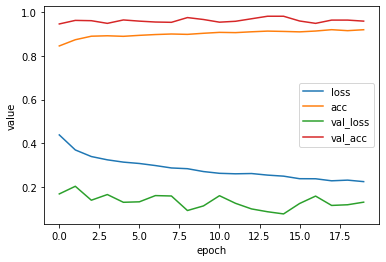

In [24]:
make_plot(H)

In [25]:
def accuracy(model, X_test, y_test, class_name=None):
  if class_name:
    labels = lb.inverse_transform(y_test)
    indices = np.where(labels == class_name)[0]
    X_test = X_test[indices]
    y_test = y_test[indices]
  test_preds = model.predict(X_test)
  m = tf.keras.metrics.CategoricalAccuracy()
  m.update_state(y_test, test_preds)
  return m.result().numpy()

In [26]:
def classification_report(model, X_test, y_test):
  classes = list(lb.classes_)
  classes = [None] + classes
  for c in classes:
    message = 'Total accuracy:' if c is None else c + ' accuracy:'
    print(message, accuracy(model, X_test, y_test, class_name=c))

In [27]:
classification_report(model, X_test, y_test)

Total accuracy: 0.79925454
incorrect accuracy: 0.17307693
with_mask accuracy: 0.8018868
without_mask accuracy: 0.95454544


**Due to the very unbalanced dataset there is a very low accuracy when classifying images with an incorrectly worn mask.**